### Weather Disaster Prediction 
#### DS 3000 Final Project
Members: Luke Abbatessa, Daniel Gilligan, Ruby Potash, Megan Putnam 

Consulted the related data dictionary for assistance throughout the assignment
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Bulk-csv-Format.pdf

Consulted stack overflow for a NotJSONError error
https://stackoverflow.com/questions/32103772/unreadable-notebook-notjsonerrornotebook-does-not-appear-to-be-json-u-n#:~:text=An%20easy%20way%20to%20check%20errors%20in%20json,open%20the%20nb%20again%20as%20usual%20%E2%80%93%20Lucas

**Data Information**

Data set: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/

Datasets include three types of data related to weather events recorded for a given year: 
1. Storm details
2. Fatalities
3. Locations 

Naming convention for the csv files are as follows: "StormEvents_[file_type]-ftp_v1.0_d[data_year]_c[creation_date].csv.gz"

In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [2]:
# Set data paths and columns of interest

LOCATIONS_2021 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2021_c20221116.csv.gz"
DETAILS_2021 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2021_c20221116.csv.gz"
FATALITIES_2021 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2021_c20221116.csv.gz"

LOCATIONS_2020 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2020_c20220816.csv.gz"
DETAILS_2020 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2020_c20220816.csv.gz"
FATALITIES_2020 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2020_c20220816.csv.gz"

LOCATIONS_2019 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2019_c20220425.csv.gz"
DETAILS_2019 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2019_c20220425.csv.gz"
FATALITIES_2019 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2019_c20220425.csv.gz"

LOCATIONS_2018 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2018_c20220425.csv.gz"
FATALITIES_2018 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2018_c20220425.csv.gz"
DETAILS_2018 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2018_c20220425.csv.gz"

LOCATIONS_2017 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2017_c20220719.csv.gz"
FATALITIES_2017 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2017_c20220719.csv.gz"
DETAILS_2017 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2017_c20220719.csv.gz"

LOCATIONS_2016 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2016_c20220719.csv.gz"
DETAILS_2016 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2016_c20220719.csv.gz"
FATALITIES_2016 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2016_c20220719.csv.gz"

LOCATIONS_2015 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2015_c20220425.csv.gz"
DETAILS_2015 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_c20220425.csv.gz"
FATALITIES_2015 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2015_c20220425.csv.gz"

LOCATIONS_2014 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2014_c20221018.csv.gz"
DETAILS_2014 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20221018.csv.gz"
FATALITIES_2014 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2014_c20221018.csv.gz"

LOCATIONS_2013 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2013_c20220425.csv.gz"
DETAILS_2013 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20220425.csv.gz"
FATALITIES_2013 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2013_c20220425.csv.gz"

LOCATIONS_2012 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_locations-ftp_v1.0_d2012_c20220425.csv.gz"
DETAILS_2012 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20220425.csv.gz"
FATALITIES_2012 = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_fatalities-ftp_v1.0_d2012_c20220425.csv.gz"



COLS_OF_INTEREST = [
    "EVENT_ID", "BEGIN_YEARMONTH", "END_YEARMONTH", "EVENT_TYPE", "CZ_TYPE", "EPISODE_NARRATIVE", 
    "EVENT_NARRATIVE", "INJURIES_DIRECT", "DEATHS_DIRECT", "DAMAGE_PROPERTY", "DAMAGE_CROPS", 
    'TOR_F_SCALE','TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
    'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME'
]

In [3]:
# Helper functions 

def merge_dfs(df1, df2, col):
    """Merge two dataframes on a common column"""
    joined_df = pd.merge(df1, df2, on=col)
    return joined_df

def year_data_import(loc_csv, detail_csv, fatal_csv, merge_on="EVENT_ID"): 
    """Returns df of merged location, detail, and fatalities csv files 
    for a given year (default is merge on event ID)"""
    loc_df = pd.read_csv(loc_csv)
    detail_df = pd.read_csv(detail_csv)
    fatal_df = pd.read_csv(fatal_csv)
    
    loc_detail_df = merge_dfs(loc_df, detail_df, merge_on)
    joined_df = merge_dfs(loc_detail_df, fatal_df, merge_on)
    
    return joined_df

def missing_data_eval(df, include_col='all'): 
    """Evaluates missing data by row and columns for given dataframe and prints output.
    Specify list of columns to include in include_col, otherwise will include all"""
    if include_col != 'all':
        df = df[include_col]  # specify subset to evaluate 
        
    print("Shape:", df.shape)
    print("\nData missing per col:", df.isnull().sum().sort_values(ascending=False), sep="\n")
    print("\nNumber of rows (right) missing X columns (left)):", df.isnull().sum(axis=1).value_counts(), sep="\n")
    
def scrutinize_data(df, col_lst):
    """Observe each column's values and their frequencies"""
    for col in col_lst:
        print(df[col].value_counts(dropna=False))

def split_date(df, date_col_name, new_names):
    """Splits yearmonth column into separate year and month columns.
    Returns updated df with given naming convention 
    (new_names: list in order of year, month col names)"""
    df[new_names[0]] = df[date_col_name].str[:4]
    df[new_names[1]] = df[date_col_name].str[4:]
    return df

def get_unique_col_vals(df):
    """Gather unique values from each dataframe column"""
    for col in df:
        print(df[col].unique())
        
def identify_data_dims(df):
    """Investigate the dimensions of a dataframe"""
    data_dims = df.shape
    return data_dims
    
def perform_deletion(df):
    """Delete rows with missing variables""" 
    df = df.dropna()
    return df

Consulted Statistics Globe to confirm the process of merging two Pandas DataFrames
https://statisticsglobe.com/merge-pandas-dataframes-based-on-particular-column-python#:~:text=Within%20this%20function%2C%20we%20have%20to%20specify%20the,on%20%3D%20%22col%22%29%20print%28data_join%29%20%23%20Print%20merged%20DataFrame

In [4]:
# Merge data type files for each year and concatenate into on df

df_2021 = year_data_import(LOCATIONS_2021, DETAILS_2021, FATALITIES_2021)
df_2020 = year_data_import(LOCATIONS_2020, DETAILS_2020, FATALITIES_2020)
df_2019 = year_data_import(LOCATIONS_2019, DETAILS_2019, FATALITIES_2019)
df_2018 = year_data_import(LOCATIONS_2018, DETAILS_2018, FATALITIES_2018)
df_2017 = year_data_import(LOCATIONS_2017, DETAILS_2017, FATALITIES_2017)
df_2016 = year_data_import(LOCATIONS_2016, DETAILS_2016, FATALITIES_2016)
df_2015 = year_data_import(LOCATIONS_2015, DETAILS_2015, FATALITIES_2015)
df_2014 = year_data_import(LOCATIONS_2014, DETAILS_2014, FATALITIES_2014)
df_2013 = year_data_import(LOCATIONS_2013, DETAILS_2013, FATALITIES_2013)
df_2012 = year_data_import(LOCATIONS_2012, DETAILS_2012, FATALITIES_2012)

joined_df = pd.concat([df_2021, df_2020, df_2019, df_2018, 
                       df_2017, df_2016, df_2015, df_2014, 
                       df_2013, df_2012])  # merge into one df

display(joined_df)

,YEARMONTH,EPISODE_ID_x,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,...,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH
0,202102,155272,936331,1,2.96,SSW,KAHAKULOA,20.9611,-156.5692,2057666,...,202102,18,0,42429,I,02/18/2021 00:00:00,26.0,F,In Water,202102.0
1,202102,155272,936331,2,1.58,N,KIPAHULU,20.6725,-156.0739,2040350,...,202102,18,0,42429,I,02/18/2021 00:00:00,26.0,F,In Water,202102.0
2,202102,155279,936389,1,1.60,NW,WAIHEE,20.9455,-156.5385,2056730,...,202102,27,0,42430,I,02/27/2021 00:00:00,27.0,M,In Water,202102.0
3,202102,155279,936389,1,1.60,NW,WAIHEE,20.9455,-156.5385,2056730,...,202102,27,0,42431,I,02/27/2021 00:00:00,NaN,M,In Water,202102.0
4,202102,155279,936389,2,1.01,NNW,KIPAHULU,20.6640,-156.0743,2039840,...,202102,27,0,42430,I,02/27/2021 00:00:00,27.0,M,In Water,202102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,201203,61699,369430,2,2.64,ESE,WIGGONSVILLE,38.9035,-84.0357,3854210,...,201203,2,0,17960,D,03/02/2012 00:00:00,54.0,M,Mobile/Trailer Home,201203.0
423,201203,61699,369430,2,2.64,ESE,WIGGONSVILLE,38.9035,-84.0357,3854210,...,201203,2,0,17962,D,03/02/2012 00:00:00,58.0,M,Mobile/Trailer Home,201203.0
424,201203,61699,369430,2,2.64,ESE,WIGGONSVILLE,38.9035,-84.0357,3854210,...,201203,2,0,17961,D,03/02/2012 00:00:00,64.0,F,Permanent Home,201203.0
425,201203,61699,370174,1,0.99,NE,WEST UNION,38.8110,-83.5182,3848660,...,201203,2,0,18120,D,03/02/2012 00:00:00,99.0,F,Mobile/Trailer Home,201203.0


In [5]:
# Remove duplicates
print("Dimen before duplicate drop:", joined_df.shape)
joined_df.drop_duplicates(inplace=True)

# Evaluate missing data counts for columns of interest and rows 
missing_data_eval(joined_df, include_col=COLS_OF_INTEREST)


Dimen before duplicate drop: (7056, 71)
Shape: (7056, 18)

Data missing per col:
TOR_OTHER_CZ_NAME     6516
TOR_OTHER_CZ_FIPS     6516
TOR_OTHER_CZ_STATE    6516
TOR_OTHER_WFO         6516
TOR_F_SCALE           6086
TOR_WIDTH             6086
TOR_LENGTH            6086
DAMAGE_PROPERTY        369
DAMAGE_CROPS           282
EVENT_NARRATIVE         31
DEATHS_DIRECT            0
BEGIN_YEARMONTH          0
INJURIES_DIRECT          0
EPISODE_NARRATIVE        0
CZ_TYPE                  0
EVENT_TYPE               0
END_YEARMONTH            0
EVENT_ID                 0
dtype: int64

Number of rows (right) missing X columns (left)):
7    5887
4     332
0     316
1     194
8     112
9      87
5      54
6      44
2      30
dtype: int64


There were no duplicate records present. Missing data shows that tornado specific feature columns ("TOR_\*")are missing from many of the records, due to not being applicable for event type. Property damage and crop damage variables are only other features of interest missing values.

In [6]:
# Check for invalid data
print("Below are the unique values by column and their frequencies.")
scrutinize_data(joined_df, COLS_OF_INTEREST)

Below are the unique values by column and their frequencies.
720861    304
505782    172
643304     96
737349     84
581658     70
         ... 
762346      1
506440      1
506947      1
524765      1
839173      1
Name: EVENT_ID, Length: 1508, dtype: int64
201708    558
201505    269
201512    248
201606    234
201305    230
         ... 
201411      4
201211      4
201710      2
202010      2
201712      1
Name: BEGIN_YEARMONTH, Length: 119, dtype: int64
201708    558
201505    269
201512    248
201606    234
201305    230
         ... 
201411      4
201211      4
201710      2
202010      2
201712      1
Name: END_YEARMONTH, Length: 119, dtype: int64
Flash Flood                 3537
Flood                       1293
Tornado                      970
Thunderstorm Wind            436
Debris Flow                  339
Lightning                    270
Heavy Rain                   103
Marine Strong Wind            46
Marine Thunderstorm Wind      41
Hail                           9
Waterspo

Based on our exploration of the data, we did not seem to come across any invalid values (e.g. each of the unique values for each of the 18 columns in the dataframe make sense in the context of ths situation).

With that being said, we have not deemed it necessary to filter out any rows from the dataframe.

In [7]:
# Filter the joined dataframe based on the columns of interest
filtered_df = joined_df[COLS_OF_INTEREST]
display(filtered_df.head(5))

print(filtered_df.dtypes)

,EVENT_ID,BEGIN_YEARMONTH,END_YEARMONTH,EVENT_TYPE,CZ_TYPE,EPISODE_NARRATIVE,EVENT_NARRATIVE,INJURIES_DIRECT,DEATHS_DIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME
0,936331,202102,202102,Heavy Rain,C,"A surface front stalled near Kauai, along with...",A 26-year-old woman died when she was swept ou...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,936331,202102,202102,Heavy Rain,C,"A surface front stalled near Kauai, along with...",A 26-year-old woman died when she was swept ou...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,936389,202102,202102,Heavy Rain,C,Gusty trade winds helped keep showers moving a...,Two hikers went missing along the Waikamoi Tra...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,936389,202102,202102,Heavy Rain,C,Gusty trade winds helped keep showers moving a...,Two hikers went missing along the Waikamoi Tra...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,936389,202102,202102,Heavy Rain,C,Gusty trade winds helped keep showers moving a...,Two hikers went missing along the Waikamoi Tra...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN


EVENT_ID                int64
BEGIN_YEARMONTH         int64
END_YEARMONTH           int64
EVENT_TYPE             object
CZ_TYPE                object
EPISODE_NARRATIVE      object
EVENT_NARRATIVE        object
INJURIES_DIRECT         int64
DEATHS_DIRECT           int64
DAMAGE_PROPERTY        object
DAMAGE_CROPS           object
TOR_F_SCALE            object
TOR_LENGTH            float64
TOR_WIDTH             float64
TOR_OTHER_WFO          object
TOR_OTHER_CZ_STATE     object
TOR_OTHER_CZ_FIPS     float64
TOR_OTHER_CZ_NAME      object
dtype: object


Consulted stack overflow for making a new column from the string slice of another
https://stackoverflow.com/questions/25789445/pandas-make-new-column-from-string-slice-of-another-column

In [8]:
# Change BEGIN_YEARMONTH and END_YEARMONTH from objects to strings to allow for slicing
dtype_dict = {"BEGIN_YEARMONTH":pd.StringDtype(), "END_YEARMONTH": pd.StringDtype()}
filtered_df = filtered_df.astype(dtype_dict)

# Separate BEGIN_YEARMONTH and END_YEARMONTH into year and month columns
filtered_df = split_date(filtered_df, "BEGIN_YEARMONTH", ["BEGIN_YEAR", "BEGIN_MONTH"]) 
filtered_df = split_date(filtered_df, "END_YEARMONTH", ["END_YEAR", "END_MONTH"]) 

# Drop the now-unnecessary columns BEGIN_YEARMONTH and END_YEARMONTH
filtered_df = filtered_df.drop(["BEGIN_YEARMONTH", "END_YEARMONTH"], axis=1)

print(filtered_df.columns)
display(filtered_df.head(5))


Index(['EVENT_ID', 'EVENT_TYPE', 'CZ_TYPE', 'EPISODE_NARRATIVE',
       'EVENT_NARRATIVE', 'INJURIES_DIRECT', 'DEATHS_DIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'TOR_F_SCALE', 'TOR_LENGTH',
       'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS',
       'TOR_OTHER_CZ_NAME', 'BEGIN_YEAR', 'BEGIN_MONTH', 'END_YEAR',
       'END_MONTH'],
      dtype='object')


,EVENT_ID,EVENT_TYPE,CZ_TYPE,EPISODE_NARRATIVE,EVENT_NARRATIVE,INJURIES_DIRECT,DEATHS_DIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_YEAR,BEGIN_MONTH,END_YEAR,END_MONTH
0,936331,Heavy Rain,C,"A surface front stalled near Kauai, along with...",A 26-year-old woman died when she was swept ou...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,02,2021,02
1,936331,Heavy Rain,C,"A surface front stalled near Kauai, along with...",A 26-year-old woman died when she was swept ou...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,02,2021,02
2,936389,Heavy Rain,C,Gusty trade winds helped keep showers moving a...,Two hikers went missing along the Waikamoi Tra...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,02,2021,02
3,936389,Heavy Rain,C,Gusty trade winds helped keep showers moving a...,Two hikers went missing along the Waikamoi Tra...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,02,2021,02
4,936389,Heavy Rain,C,Gusty trade winds helped keep showers moving a...,Two hikers went missing along the Waikamoi Tra...,0,0,0.00K,0.00K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,02,2021,02


In [9]:
# Change the types of certain columns
dtype_dict = {"EVENT_TYPE":pd.StringDtype(), 
              "CZ_TYPE": pd.StringDtype(), 
              "EPISODE_NARRATIVE":pd.StringDtype(), 
              "EVENT_NARRATIVE":pd.StringDtype(),
              "TOR_F_SCALE":pd.StringDtype(), 
              "TOR_LENGTH":float, 
              "TOR_WIDTH":float,
              "TOR_OTHER_WFO":pd.StringDtype(),
              "TOR_OTHER_CZ_STATE":pd.StringDtype(), 
              "TOR_OTHER_CZ_FIPS":float, 
              "TOR_OTHER_CZ_NAME":pd.StringDtype(),
              "BEGIN_YEAR":int,
              "BEGIN_MONTH":int,
              "END_YEAR":int,
              "END_MONTH":int}

filtered_df = filtered_df.astype(dtype_dict)
print(filtered_df.dtypes)


EVENT_ID                int64
EVENT_TYPE             string
CZ_TYPE                string
EPISODE_NARRATIVE      string
EVENT_NARRATIVE        string
INJURIES_DIRECT         int64
DEATHS_DIRECT           int64
DAMAGE_PROPERTY        object
DAMAGE_CROPS           object
TOR_F_SCALE            string
TOR_LENGTH            float64
TOR_WIDTH             float64
TOR_OTHER_WFO          string
TOR_OTHER_CZ_STATE     string
TOR_OTHER_CZ_FIPS     float64
TOR_OTHER_CZ_NAME      string
BEGIN_YEAR              int64
BEGIN_MONTH             int64
END_YEAR                int64
END_MONTH               int64
dtype: object


In [10]:
# Clean property damage and crop damage columns to convert to numeric data 
# Replace "K" with (3 zeros - 2), "M" with (6 - 2), 
# "B" with (9 - 2), and "." with "" for DAMAGE_PROPERTY and DAMAGE_CROPS
# 
# Already 2 0's after a decimal point for both columns
letter_num = {"K": "0"*(3-2), "M": "0"*(6-2), "B": "0"*(9-2), ".": ""}
    
filtered_df["DAMAGE_PROPERTY"] \
= filtered_df["DAMAGE_PROPERTY"].str.translate(str.maketrans(letter_num))

filtered_df["DAMAGE_PROPERTY"] = pd.to_numeric(filtered_df["DAMAGE_PROPERTY"])

filtered_df["DAMAGE_CROPS"] \
= filtered_df["DAMAGE_CROPS"].str.translate(str.maketrans(letter_num))

filtered_df["DAMAGE_CROPS"] = pd.to_numeric(filtered_df["DAMAGE_CROPS"])

        
get_unique_col_vals(filtered_df)  # get unique column values for df 

[936331 936389 975717 ... 369474 369430 370174]
<StringArray>
[              'Heavy Rain',                'Lightning',
              'Flash Flood',                  'Tornado',
        'Thunderstorm Wind',       'Marine Strong Wind',
                    'Flood',              'Debris Flow',
                     'Hail', 'Marine Thunderstorm Wind',
               'Waterspout',         'Marine High Wind',
               'Dust Devil']
Length: 13, dtype: string
<StringArray>
['C', 'Z']
Length: 2, dtype: string
<StringArray>
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [11]:
# Filter the df by tornadoes, and gauge the missing values in the tornado df
tornado_df = filtered_df[filtered_df["EVENT_TYPE"] == "Tornado"]
display(tornado_df.head(5))

missing_data_eval(tornado_df)


,EVENT_ID,EVENT_TYPE,CZ_TYPE,EPISODE_NARRATIVE,EVENT_NARRATIVE,INJURIES_DIRECT,DEATHS_DIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_YEAR,BEGIN_MONTH,END_YEAR,END_MONTH
14,979869,Tornado,C,A tornado that touched down in Jefferson Count...,An EF-1 tornado was confirmed to have occurred...,1,1,20000.0,0.0,EF1,0.58,260.0,<NA>,<NA>,NaN,<NA>,2021,10,2021,10
15,979869,Tornado,C,A tornado that touched down in Jefferson Count...,An EF-1 tornado was confirmed to have occurred...,1,1,20000.0,0.0,EF1,0.58,260.0,<NA>,<NA>,NaN,<NA>,2021,10,2021,10
150,972354,Tornado,C,The remnants of Hurricane Ida impacted the mid...,A semi-discrete supercell thunderstorm began t...,2,1,5000000.0,0.0,EF2,8.28,400.0,<NA>,<NA>,NaN,<NA>,2021,9,2021,9
151,972354,Tornado,C,The remnants of Hurricane Ida impacted the mid...,A semi-discrete supercell thunderstorm began t...,2,1,5000000.0,0.0,EF2,8.28,400.0,<NA>,<NA>,NaN,<NA>,2021,9,2021,9
154,941340,Tornado,C,A very moist and moderately unstable airmass o...,A National Weather Service survey determined t...,0,0,20000000.0,NaN,EF4,21.72,1850.0,FFC,GA,113.0,FAYETTE,2021,3,2021,3


Shape: (970, 20)

Data missing per col:
TOR_OTHER_CZ_NAME     430
TOR_OTHER_CZ_FIPS     430
TOR_OTHER_CZ_STATE    430
TOR_OTHER_WFO         430
DAMAGE_PROPERTY       234
DAMAGE_CROPS          162
EVENT_ID                0
TOR_WIDTH               0
END_YEAR                0
BEGIN_MONTH             0
BEGIN_YEAR              0
TOR_LENGTH              0
EVENT_TYPE              0
TOR_F_SCALE             0
DEATHS_DIRECT           0
INJURIES_DIRECT         0
EVENT_NARRATIVE         0
EPISODE_NARRATIVE       0
CZ_TYPE                 0
END_MONTH               0
dtype: int64

Number of rows (right) missing X columns (left)):
4    332
0    316
1    194
5     54
6     44
2     30
dtype: int64


In [12]:
# Perform deletion and observe tornado_df's dimensions 
# before and after
initial_dims = identify_data_dims(tornado_df)
print("Below are the initial dimensions of tornado_df.")
print(initial_dims)
print(" ")

tornado_df = perform_deletion(tornado_df)
final_dims = identify_data_dims(tornado_df)
print("Below are the dimensions of tornado_df after "
      "missing values are deleted.")
print(final_dims)
print(" ")

print("After deletion,", initial_dims[0] - final_dims[0], "rows "
      "were removed from the data.")

Below are the initial dimensions of tornado_df.
(970, 20)
 
Below are the dimensions of tornado_df after missing values are deleted.
(316, 20)
 
After deletion, 654 rows were removed from the data.


/Users/lukeabbatessa/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


The mse of the model with 500 trees is: 32,955,236,542,712.5
The coefficient of determination of the model with 500 trees is: 0.9995

The mse of the model with 100 trees is: 44,749,489,845,468.75
The coefficient of determination of the model with 100 trees is: 0.9993



/Users/lukeabbatessa/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lukeabbatessa/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


The mse of the model with 50 trees is: 29,143,515,948,750.0
The coefficient of determination of the model with 50 trees is: 0.9996

The mean value for the target varable is : 60,507,658.23
The median value for the target varable is: 2,000,000.0


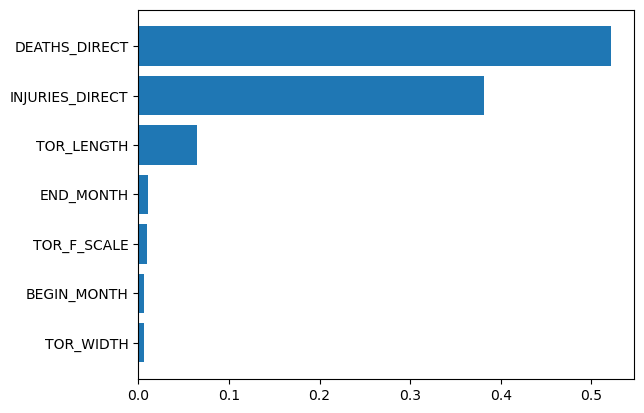

In [13]:
# Random forest regression

# Setting up our variables
X = tornado_df.drop(['DAMAGE_PROPERTY'], axis=1)
y = tornado_df['DAMAGE_PROPERTY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train = X_train[['INJURIES_DIRECT',	'DEATHS_DIRECT',	'TOR_F_SCALE',	'TOR_LENGTH',	'TOR_WIDTH',	'BEGIN_MONTH',	'END_MONTH']]
X_test = X_test[['INJURIES_DIRECT',	'DEATHS_DIRECT',	'TOR_F_SCALE',	'TOR_LENGTH',	'TOR_WIDTH',	'BEGIN_MONTH',	'END_MONTH']]

# Converting the f scale to just a number 
# Ex. EF3 ===> 3
number_f_scale_train = []
for entry in X_train['TOR_F_SCALE']:
  entry = entry[len(entry) - 1]
  number_f_scale_train.append(entry)
X_train['TOR_F_SCALE'] = number_f_scale_train

number_f_scale_test = []
for entry in X_test['TOR_F_SCALE']:
  entry = entry[len(entry) - 1]
  number_f_scale_test.append(entry)
X_test['TOR_F_SCALE'] = number_f_scale_test

# Training the model with different # of trees
rf_model_500 = RandomForestRegressor(n_estimators=500, max_features='auto', random_state=44)
rf_model_500.fit(X_train, y_train)
cd = rf_model_500.score(X_train, y_train)
y_pred = rf_model_500.predict(X_test)
mse = mean_squared_error(y_test, y_pred).round(2)
print('The mse of the model with 500 trees is: ' + f"{mse:,}")
print('The coefficient of determination of the model with 500 trees is: ' + f"{round(cd,4)}\n")


rf_model_100 = RandomForestRegressor(n_estimators=100, max_features='auto', random_state=44)
rf_model_100.fit(X_train, y_train)
cd = rf_model_100.score(X_train, y_train)
y_pred = rf_model_100.predict(X_test)
mse = mean_squared_error(y_test, y_pred).round(2)
print('The mse of the model with 100 trees is: ' + f"{mse:,}")
print('The coefficient of determination of the model with 100 trees is: ' + f"{round(cd,4)}\n")


rf_model_50 = RandomForestRegressor(n_estimators=50, max_features='auto', random_state=44)
rf_model_50.fit(X_train, y_train)
cd = rf_model_50.score(X_train, y_train)
y_pred = rf_model_50.predict(X_test)
mse = mean_squared_error(y_test, y_pred).round(2)
print('The mse of the model with 50 trees is: ' + f"{mse:,}")
print('The coefficient of determination of the model with 50 trees is: ' + f"{round(cd,4)}\n")



sorted_idx = rf_model_50.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_model_50.feature_importances_[sorted_idx])

mean = round(y.mean(), 2)
median = y.median()
print('The mean value for the target varable is : ' + f"{mean:,}")
print('The median value for the target varable is: ' + f"{median:,}")


Consulted Great Learning for more information about mean squared error
https://www.mygreatlearning.com/blog/mean-square-error-explained/

Consulted CFI for more information about the coefficient of determination
https://corporatefinanceinstitute.com/resources/data-science/coefficient-of-determination/

One of the three algorithms that we implemented was a Random Forest Regressor; we chose to implement a Random Forest Regressor and not a Random Forest Classifier because the variable we were trying to predict ("DAMAGE_PROPERTY") represented a numerical variable.

One hyperparameter that we decided to tune was "n_estimators," which indicates the number of trees included in the model. Specifically, we trained the model with 500 trees, 100 trees, and 50 trees, and the differing numbers of trees had an influence on the two metrics we used to gauge the performance of the model: mean squared error (MSE) and the coefficient of determination.

MSE can be defined as the mean or average of the square of the difference between actual values and estimated values. MSE can be used to find a line-of-best-fit, however it is sensitive to outliers. The larger the MSE, the farther that estimated values are from their actual counterparts; the smaller the MSE, the better that the estimated values resemble the actual values.

The coefficient of determination (also called r-squared) determines the proportion of variance in the dependent variable (the variable representative of the y-axis) that can be explained by the independent variable (the variable representative of the x-axis). In other words, the coefficient of determination indicates how well the data fits the model. The closer the r-squared value is to 1, the more of an indication that the data is a good fit for the model.

Beginning with the implementation of the Random Forest Regressor with 500 trees, the MSE was roughly 32,955,236,542,712.50, while the r-squared value was roughly 0.9995. Although the r-squared value being high is a good thing, the same cannot be said for the MSE, however this was the first implementation of the model, so there was room for improvement. Thus "n_estimators" was changed to 100.

Looking at the implementation of the model with 100 trees, the MSE was roughly 44,749,489,845,468.75, while the r-squared value was roughly 0.9993. Both the MSE and the r-squared value for this implementation of the model were worse than the MSE and the r-squared value for the implementation of the model with 500 trees, thus "n_estimators" was once again tuned, this time to 50.

Looking at the implementation of the model with 50 trees, the MSE was roughly 29,143,515,948,750.00, while thr r-squared value was roughly 0.9996. This MSE value was better than the previous two MSE values, however it is still considerably high; this r-squared value was better than the previous two r-squared values. Overall, the high MSE for each of the three models is an indication that a Random Forest Regressor may not be the best model for predicting "DAMAGE_PROPERTY" from tornadoes based on "INJURIES_DIRECT," "DEATHS_DIRECT," "TOR_F_SCALE," "TOR_LENGTH," "TOR_WIDTH," "BEGIN_MONTH," and "END_MONTH."

Lastly, looking at the horizontal bar chart above, it illustrates which features were most important in predicting "DAMAGE_PROPERTY." As one can see, the top three features were "DEATHS_DIRECT," "INJURIES_DIRECT," and "TOR_LENGTH," with relative importance scores of roughly 0.52, 0.39, and 0.08, respectively.

In [14]:
# knn regression

# replacing categorical variables with dummies
tornado_df = pd.get_dummies(tornado_df, columns = ['TOR_F_SCALE'])

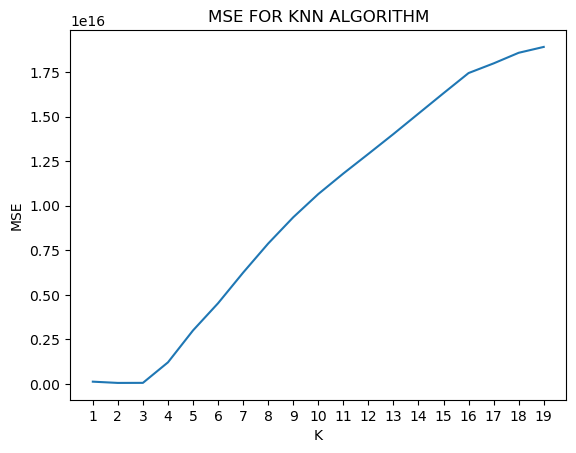

In [15]:
# set up our variables
X = tornado_df.drop(['DAMAGE_PROPERTY'], axis=1)
y = tornado_df['DAMAGE_PROPERTY']

# partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

X_train = X_train[['INJURIES_DIRECT' , 'DEATHS_DIRECT', 'TOR_LENGTH', 'TOR_WIDTH', 'BEGIN_MONTH' , 'END_MONTH',
                  'TOR_F_SCALE_EF1', 'TOR_F_SCALE_EF2' , 'TOR_F_SCALE_EF3' , 'TOR_F_SCALE_EF4']]

X_test = X_test[['INJURIES_DIRECT' , 'DEATHS_DIRECT', 'TOR_LENGTH', 'TOR_WIDTH', 'BEGIN_MONTH' , 'END_MONTH',
                  'TOR_F_SCALE_EF1', 'TOR_F_SCALE_EF2' , 'TOR_F_SCALE_EF3' , 'TOR_F_SCALE_EF4']]


# perform algorithm
mse = {}
cd = {}
k_range = range(1,20)
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse[k] = round(mean_squared_error(y_test, y_pred),2)
    cd[k] = knn.score(X_train, y_train)
    

# plot various values of MSE by k
plt.plot(k_range, mse.values())
plt.title('MSE FOR KNN ALGORITHM')
plt.xlabel('K')
plt.ylabel('MSE')
plt.xticks(k_range)
plt.show()

    

It appears K = 2 has the best value for mse.

In [16]:
knn = KNeighborsRegressor(n_neighbors = 2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('The coefficient of determination for k = 2 is', round(cd[2],4))
print('The MSE for k = 2 is', round(mean_squared_error(y_test, y_pred),2))


The coefficient of determination for k = 2 is 0.9998
The MSE for k = 2 is 57479674218750.0


The next algorithm we chose to implement was a K-nearest neighbor regression to predict the continuous property damage variable (“DAMAGE_PROPERTY”). 

We hypertuned the value of k, the number of neighbors that were used to determine the predicted damage value given our features of injuries, deaths, tornado length, tornado width, beginning month, ending month, and Fujita scale rating. We tested k values of 1 to 20 for a total of 19 k values, and measured model performance using MSE (as described above) and coefficient of determination. 

The KNN regression model performed best with a k value of 2, which had the lowest MSE value (57,479,674,218,750.00). This is a large MSE (greater than the top performing random forest model); however, the property damage data had a wide spread/variance, which could account for the large mean square error. The coefficient of determination for the k = 2 model was 0.9998, indicating a good fit of the model to the data. However, with the large MSE value, it can be concluded that this model is not optimal for predicting tornado property damages. 


The MSE is 3.0200635604434236e+16
The coefficient of determination is 0.09


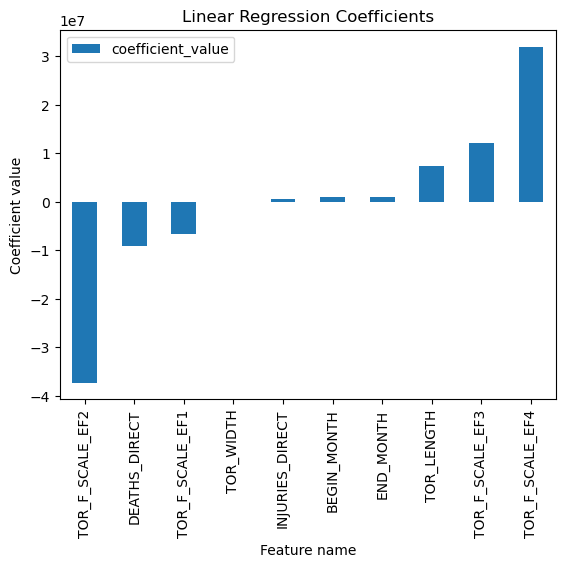

In [17]:
# Multiple Linear Regression

# using same train, test data as above

# create model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict
y_pred = lr.predict(X_test)

# get feature coefficients and plot values 
coef_values = {lr.feature_names_in_[i] : lr.coef_[i] for i in range(len(lr.feature_names_in_))}  # extracts feature names and coefficient values 
coefs = pd.DataFrame.from_dict(coef_values, orient='index', columns=['coefficient_value']).sort_values(by='coefficient_value')

coefs.plot(kind='bar')
plt.title('Linear Regression Coefficients') 
plt.xlabel('Feature name')
plt.ylabel('Coefficient value')

# MSE and coefficient of determination
print('The MSE is', mean_squared_error(y_test, y_pred))
print('The coefficient of determination is', round(lr.score(X_test, y_test),2))


The last algorithm we implemented was a multiple linear regression. We used the same features as in the other models tested and evaluated model performance using MSE and coefficient of determination again. The MSE value was once again very large (3.02e+16) — indeed, larger than both of the other models tested. The coefficient of determination was low as well (0.09), indicating that the multiple linear regression was not a good fit for the data. This suggested that the model was not the best choice for predicting tornado damages based on the input features. 

Additionally, based on analysis of the feature coefficients, the most influential features were F scale ratings of 4 (positive correlation vaule) and 2 (negative correlation value).    

Taking all three algorithms that we implemented into account, we conclude that the best algorithm was the Random Forest Regressor, specifically with 50 trees. Although the K Neighbors Regressor with 2 neighbors had the highest coefficient of determination with 0.9998, the Random Forest Regressor with 50 trees had both the second-highest coefficient of determination of 0.9996 and the smallest MSE of 29,143,515,948,750.00.

The r-squared value being as close to 1 as it is signifies that the data is a considerably good fit for the model. Additionally, although the MSE is considerably large, the fact that the Random Forest Regressor with 50 trees has the smallest MSE signifies that the estimated values for property damage from tornadoes best resemble the actual values in the data relative to this model.